# Likelihood Ratio Outlier Detection on Genomic Sequences

## Method

The outlier detector described by [Ren et al. (2019)](https://arxiv.org/abs/1906.02845) in [Likelihood Ratios for Out-of-Distribution Detection](https://arxiv.org/abs/1906.02845) uses the likelihood ratio between 2 generative models as the outlier score. One model is trained on the original data while the other is trained on a perturbed version of the dataset. This is based on the observation that the likelihood score for an instance under a generative model can be heavily affected by population level background statistics. The second generative model is therefore trained to capture the background statistics still present in the perturbed data while the semantic features have been erased by the perturbations.

The perturbations are added using an independent and identical Bernoulli distribution with rate $\mu$ which substitutes a feature with one of the other possible feature values with equal probability. Each feature in the genome dataset can take 4 values (one of the ACGT nucleobases). This means that a perturbed feature is swapped with one of the other nucleobases. The generative model used in the example is a simple LSTM network.

## Dataset

The bacteria genomics dataset for out-of-distribution detection was released as part of the [Likelihood Ratios for Out-of-Distribution Detection](https://arxiv.org/abs/1906.02845) paper. From the original *TL;DR*: *The dataset contains genomic sequences of 250 base pairs from 10 in-distribution bacteria classes for training, 60 OOD bacteria classes for validation, and another 60 different OOD bacteria classes for test*. There are respectively 1, 7 and again 7 million sequences in the training, validation and test sets. For detailed info on the dataset check the [README](https://storage.cloud.google.com/seldon-datasets/genome/readme.docx?organizationId=156002945562).

This notebook requires the `seaborn` package for visualization which can be installed via `pip`:

In [ ]:
!pip install seaborn

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM

from alibi_detect.od import LLR
from alibi_detect.datasets import fetch_genome
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_roc

### Load genome data

*X* represents the genome sequences and *y* whether they are outliers ($1$) or not ($0$).

In [2]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
        fetch_genome(return_X_y=True, return_labels=False)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000000, 250) (1000000,) (6999774, 250) (6999774,) (7000000, 250) (7000000,)


There are no outliers in the training set and a majority of outliers (compared to the training data) in the validation and test sets:

In [3]:
print('Fraction of outliers in train, val and test sets: '
      '{:.2f}, {:.2f} and {:.2f}'.format(y_train.mean(), y_val.mean(), y_test.mean()))

Fraction of outliers in train, val and test sets: 0.00, 0.86 and 0.86


### Define model

We need to define a generative model which models the genome sequences. We follow the paper and opt for a simple LSTM. Note that we don't actually need to define the model below if we simply load the pretrained detector later on:

In [4]:
genome_dim = 249  # not 250 b/c we use 1->249 as input and 2->250 as target
input_dim = 4  # ACGT nucleobases
hidden_dim = 2000

inputs = Input(shape=(genome_dim,), dtype=tf.int8)
x = tf.one_hot(tf.cast(inputs, tf.int32), input_dim)
x = LSTM(hidden_dim, return_sequences=True)(x)
logits = Dense(input_dim, activation=None)(x)
model = tf.keras.Model(inputs=inputs, outputs=logits, name='LlrLSTM')

We also need to define our loss function which we can utilize to evaluate the log-likelihood for the outlier detector:

In [5]:
def loss_fn(y, x):
    y = tf.one_hot(tf.cast(y, tf.int32), 4)  # ACGT on-hot encoding
    return tf.nn.softmax_cross_entropy_with_logits(y, x, axis=-1)

In [6]:
def likelihood_fn(y, x):
    return -loss_fn(y, x)

### Load or train the outlier detector

We can again either fetch the pretrained detector from a [Google Cloud Bucket](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/od/LLR/genome) or train one from scratch:

In [7]:
load_pretrained = True

In [8]:
filepath = os.path.join(os.getcwd(), 'my_path')  # change to download directory
detector_type = 'outlier'
dataset = 'genome'
detector_name = 'LLR'
filepath = os.path.join(filepath, detector_name)
if load_pretrained:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:
    # initialize detector
    od = LLR(threshold=None, model=model, log_prob=likelihood_fn, sequential=True)
    
    # train
    od.fit(
        X_train,
        mutate_fn_kwargs=dict(rate=.2, feature_range=(0,3)),
        mutate_batch_size=1000,
        loss_fn=loss_fn,
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        epochs=20,
        batch_size=100,
        verbose=False
    )
    
    # save the trained outlier detector
    save_detector(od, filepath)

### Compare the log likelihoods

Let's compare the log likelihoods of the inliers vs. the outlier test set data under the semantic and background models. We randomly sample $100,000$ instances from both distributions since the full test set contains $7,000,000$ genomic sequences. The histograms show that the generative model does not distinguish well between inliers and outliers.

In [9]:
idx_in, idx_ood = np.where(y_test == 0)[0], np.where(y_test == 1)[0]
n_in, n_ood = idx_in.shape[0], idx_ood.shape[0]
n_sample = 100000  # sample 100k inliers and outliers each
sample_in = np.random.choice(n_in, size=n_sample, replace=False)
sample_ood = np.random.choice(n_ood, size=n_sample, replace=False)
X_test_in, X_test_ood = X_test[idx_in[sample_in]], X_test[idx_ood[sample_ood]]
y_test_in, y_test_ood = y_test[idx_in[sample_in]], y_test[idx_ood[sample_ood]]
X_test_sample = np.concatenate([X_test_in, X_test_ood])
y_test_sample = np.concatenate([y_test_in, y_test_ood])
print(X_test_in.shape, X_test_ood.shape)

(100000, 250) (100000, 250)


In [10]:
# semantic model
logp_s_in = od.logp_alt(od.dist_s, X_test_in, batch_size=100)
logp_s_ood = od.logp_alt(od.dist_s, X_test_ood, batch_size=100)
logp_s = np.concatenate([logp_s_in, logp_s_ood])
# background model
logp_b_in = od.logp_alt(od.dist_b, X_test_in, batch_size=100)
logp_b_ood = od.logp_alt(od.dist_b, X_test_ood, batch_size=100)
logp_b = np.concatenate([logp_b_in, logp_b_ood])

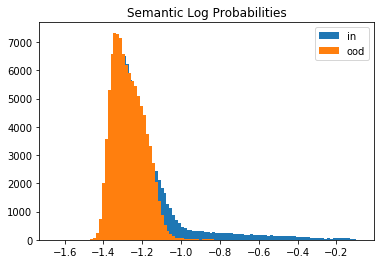

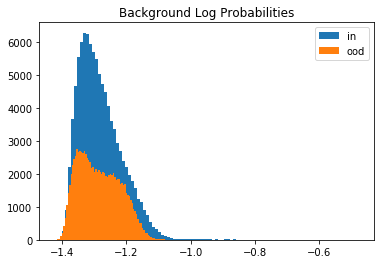

In [11]:
# show histograms
plt.hist(logp_s_in, bins=100, label='in');
plt.hist(logp_s_ood, bins=100, label='ood');
plt.title('Semantic Log Probabilities')
plt.legend()
plt.show()

plt.hist(logp_b_in, bins=100, label='in');
plt.hist(logp_b_ood, bins=100, label='ood');
plt.title('Background Log Probabilities')
plt.legend()
plt.show()

This is because of the background-effect which is in this case the GC-content in the genomic sequences. This effect is partially reduced when taking the likelihood ratio:

In [12]:
llr_in = logp_s_in - logp_b_in
llr_ood = logp_s_ood - logp_b_ood

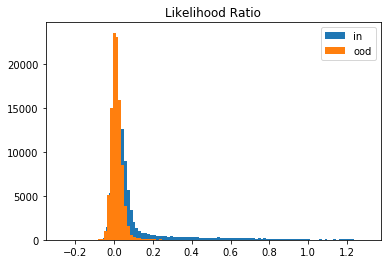

In [13]:
plt.hist(llr_in, bins=100, label='in');
plt.hist(llr_ood, bins=100, label='ood');
plt.title('Likelihood Ratio')
plt.legend()
plt.show()

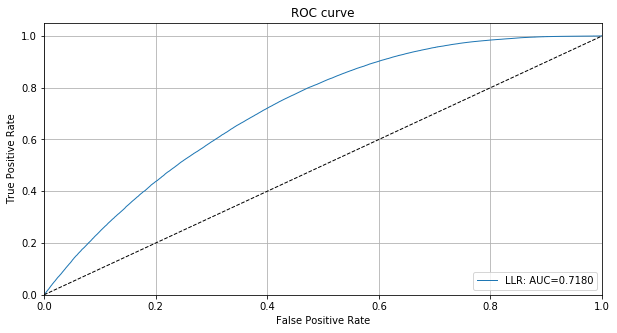

In [14]:
llr = np.concatenate([llr_in, llr_ood])
roc_data = {'LLR': {'scores': -llr, 'labels': y_test_sample}}
plot_roc(roc_data)

### Detect outliers

We follow the same procedure with the outlier detector. First we need to set an outlier threshold with `infer_threshold`. We need to pass a batch of instances and specify what percentage of those we consider to be normal via `threshold_perc`. Let's assume we have a  small batch of data with roughly $30$% outliers but we don't know exactly which ones.

In [15]:
n, frac_outlier = 1000, .3
perc_outlier = 100 * frac_outlier
n_sample_in, n_sample_ood = int(n * (1 - frac_outlier)), int(n * frac_outlier)
idx_in, idx_ood = np.where(y_val == 0)[0], np.where(y_val == 1)[0]
n_in, n_ood = idx_in.shape[0], idx_ood.shape[0]
sample_in = np.random.choice(n_in, size=n_sample_in, replace=False)
sample_ood = np.random.choice(n_ood, size=n_sample_ood, replace=False)
X_thr_in, X_thr_ood = X_val[idx_in[sample_in]], X_val[idx_ood[sample_ood]]
X_threshold = np.concatenate([X_thr_in, X_thr_ood])
print(X_threshold.shape)

(1000, 250)


In [16]:
od.infer_threshold(X_threshold, threshold_perc=perc_outlier, batch_size=100)
print('New threshold: {}'.format(od.threshold))

New threshold: -0.0506670355796814


Let's save the outlier detector with updated threshold:

In [17]:
save_detector(od, filepath)

Let'spredict outliers on a sample of the test set:

In [18]:
od_preds = od.predict(X_test_sample, batch_size=100)

### Display results

F1 score, accuracy, precision, recall and confusion matrix:

F1 score: 0.722 -- Accuracy: 0.646 -- Precision: 0.595 -- Recall: 0.919


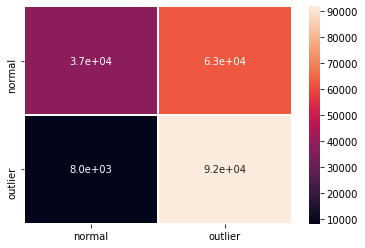

In [19]:
y_pred = od_preds['data']['is_outlier']
labels = ['normal', 'outlier']
f1 = f1_score(y_test_sample, y_pred)
acc = accuracy_score(y_test_sample, y_pred)
prec = precision_score(y_test_sample, y_pred)
rec = recall_score(y_test_sample, y_pred)
print('F1 score: {:.3f} -- Accuracy: {:.3f} -- Precision: {:.3f} '
      '-- Recall: {:.3f}'.format(f1, acc, prec, rec))
cm = confusion_matrix(y_test_sample, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

We can also plot the ROC curve based on the instance level outlier scores:

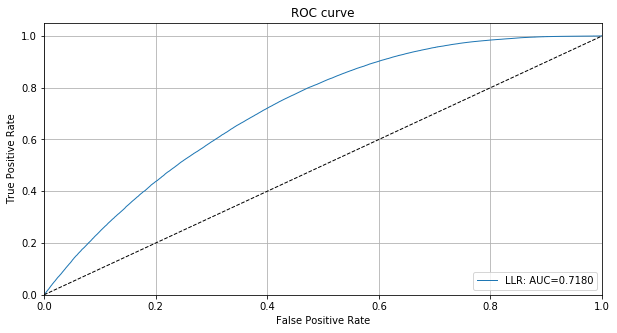

In [20]:
roc_data = {'LLR': {'scores': od_preds['data']['instance_score'], 'labels': y_test_sample}}
plot_roc(roc_data)